In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here

In [6]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation

all_xray_df = pd.read_csv('C:/data/xrays/Data_Entry_2017.csv')
all_xray_df.sample(3)

data_sample = pd.read_csv('sample_labels.csv')
data_sample.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
2791,00013952_000.png,Atelectasis|Pneumonia,0,13952,059Y,M,PA,2500,2048,0.168,0.168
5134,00027320_011.png,Effusion|Infiltration,11,27320,052Y,M,PA,2992,2991,0.143,0.143
4879,00025662_001.png,Atelectasis|Nodule,1,25662,057Y,M,AP,3056,2544,0.139,0.139


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [9]:
## EDA
# Todo 

len(all_xray_df)

112120

In [11]:
all_xray_df.iloc[0]

Image Index                    00000001_000.png
Finding Labels                     Cardiomegaly
Follow-up #                                   0
Patient ID                                    1
Patient Age                                  58
Patient Gender                                M
View Position                                PA
OriginalImage[Width                        2682
Height]                                    2749
OriginalImagePixelSpacing[x               0.143
y]                                        0.143
Unnamed: 11                                 NaN
Name: 0, dtype: object

In [14]:
# using the code from the 'exploring population metadata' exercise in this course
from itertools import chain
#labels = np.unique(list(chain))

In [15]:
d = all_xray_df.copy()

In [25]:
# this parsing trick copied directly forom the exercise
labels = np.unique(list(chain(*d['Finding Labels'].map(lambda x: x.split('|')).tolist())))

In [26]:
labels2 = [x for x in labels if len(x)>0]

In [33]:
labels2

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [29]:
# hmm anyway, for future compatibility, I suppose we can have code to remove empty labels
labels = [x for x in labels if len(x)>0]

In [31]:
# creating dummy vars for the diseases
for c_label in labels:
    d[c_label] = d['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

In [38]:
d[labels].sum()/len(d)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

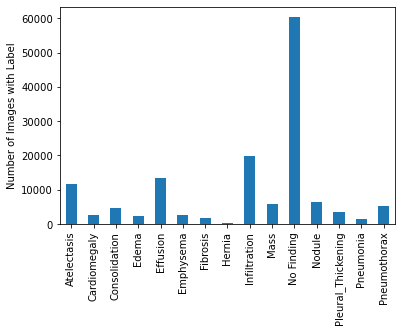

In [40]:
ax = d[labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

In [43]:
len(d[d['Finding Labels']=="No Finding"])/len(d)

0.5383606849803781

In [44]:
# We can see that 54% of the data has no Findings
# the highest 3 findings in the above graph are Atelectasis, Effusion and Infiltration

In [48]:
d[d.Infiltration==1]['Finding Labels'].value_counts()[0:10]

Infiltration                         9547
Effusion|Infiltration                1603
Atelectasis|Infiltration             1350
Infiltration|Nodule                   829
Atelectasis|Effusion|Infiltration     737
Consolidation|Infiltration            441
Infiltration|Mass                     420
Edema|Infiltration                    392
Infiltration|Pneumothorax             345
Infiltration|Pleural_Thickening       210
Name: Finding Labels, dtype: int64

<AxesSubplot:>

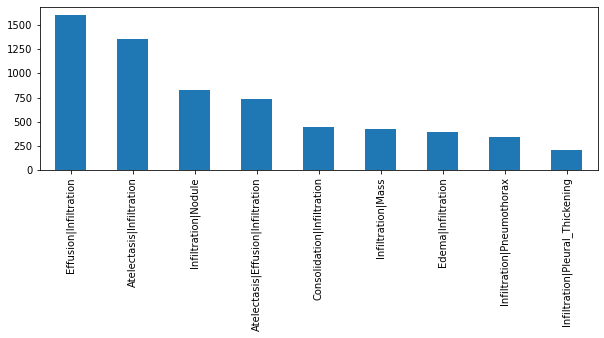

In [56]:
# it seems the 3 common ones also often appear together
plt.figure(figsize=(10,3))
d[d.Infiltration==1]['Finding Labels'].value_counts()[1:10].plot(kind='bar') # using from 1 to remove infiltration itself

<AxesSubplot:>

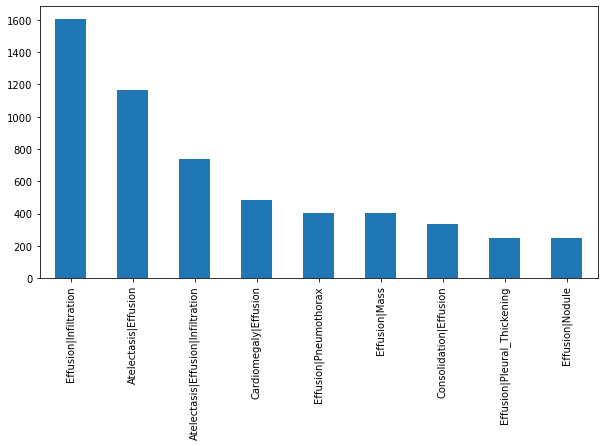

In [57]:
# it seems the 3 common ones also often appear together
plt.figure(figsize=(10,5))
d[d.Effusion==1]['Finding Labels'].value_counts()[1:10].plot(kind='bar') # using from 1 to remove infiltration itself

In [59]:
# lets see what else we have:
d.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

(array([4.1465e+04, 7.0265e+04, 3.7400e+02, 1.0000e+01, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0000e+00]),
 array([  1. ,  42.3,  83.6, 124.9, 166.2, 207.5, 248.8, 290.1, 331.4,
        372.7, 414. ]),
 <BarContainer object of 10 artists>)

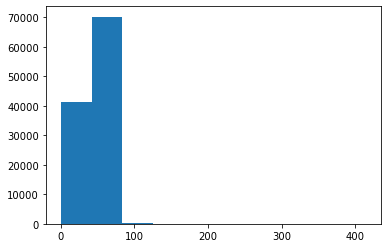

In [62]:
plt.hist(d['Patient Age'], bins =10)

In [63]:
np.max(d['Patient Age'])

414

In [74]:
# hmm, there is some outliers it seems...
d[d['Patient Age'] >100]

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [77]:
d2 = d[d['Patient Age'] < 80]

In [78]:
d2

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [81]:
len(d[d['Patient Age'] >= 80])/len(d)

0.010123082411701748

In [102]:
d = d[d['Patient Age'] < 80].copy()

(array([ 1021.,  3615.,  8256., 11668., 11375., 16931., 20794., 20353.,
        12299.,  4673.]),
 array([ 1. ,  8.8, 16.6, 24.4, 32.2, 40. , 47.8, 55.6, 63.4, 71.2, 79. ]),
 <BarContainer object of 10 artists>)

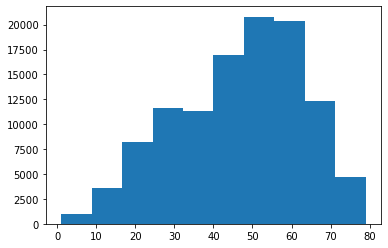

In [83]:
plt.hist(d['Patient Age'])

(array([ 233.,  741., 1537., 2287., 1929., 3010., 3432., 3516., 2177.,
         833.]),
 array([ 1. ,  8.8, 16.6, 24.4, 32.2, 40. , 47.8, 55.6, 63.4, 71.2, 79. ]),
 <BarContainer object of 10 artists>)

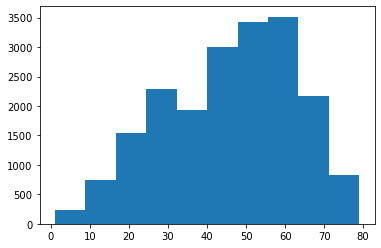

In [84]:
plt.hist(d[d.Infiltration==1]['Patient Age'])

(array([  50.,  333.,  711., 1226., 1171., 1774., 2481., 2829., 1762.,
         780.]),
 array([ 1. ,  8.8, 16.6, 24.4, 32.2, 40. , 47.8, 55.6, 63.4, 71.2, 79. ]),
 <BarContainer object of 10 artists>)

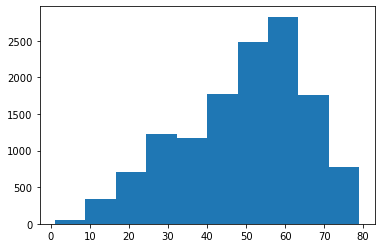

In [85]:
plt.hist(d[d.Effusion==1]['Patient Age'])

<AxesSubplot:>

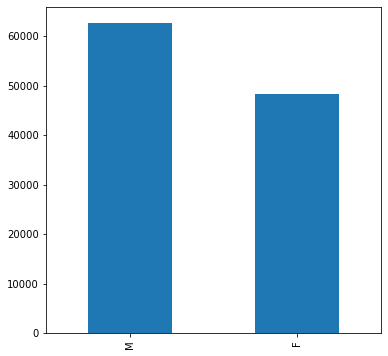

In [86]:
plt.figure(figsize=(6,6))
d['Patient Gender'].value_counts().plot(kind='bar')

<AxesSubplot:>

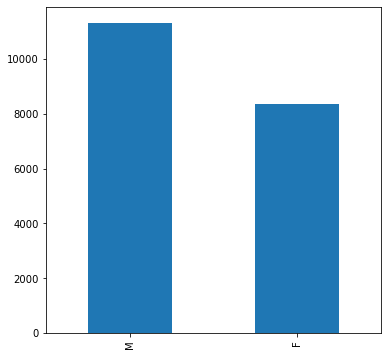

In [87]:
plt.figure(figsize=(6,6))
d[d.Infiltration ==1]['Patient Gender'].value_counts().plot(kind='bar')

<AxesSubplot:>

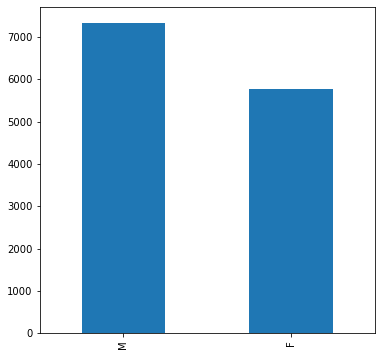

In [88]:
plt.figure(figsize=(6,6))
d[d.Effusion ==1]['Patient Gender'].value_counts().plot(kind='bar')

In [91]:
d.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')

In [99]:
all_xray_df #= pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('C:/data/xrays','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
104415,00027927_007.png,Atelectasis|Pleural_Thickening,7,27927,57,F,PA,2992,2865,0.143,0.143,NaN,C:/data/xrays\images_011\images\00027927_007.png
15568,00004082_001.png,No Finding,1,4082,60,F,PA,2550,2991,0.143,0.143,NaN,C:/data/xrays\images_003\images\00004082_001.png
62757,00015530_085.png,Emphysema,85,15530,20,M,AP,3056,2544,0.139,0.139,NaN,C:/data/xrays\images_007\images\00015530_085.png


In [95]:
all_image_paths.get

<function dict.get(key, default=None, /)>

In [96]:
all_xray_df.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN,C:/data/xrays\images_001\images\00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN,C:/data/xrays\images_001\images\00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN,C:/data/xrays\images_001\images\00000001_002.png


In [103]:
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('C:/data/xrays','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
d['path'] = d['Image Index'].map(all_image_paths.get)
d.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,path
67406,00016643_010.png,Mass,10,16643,51,F,PA,2526,2797,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,C:/data/xrays\images_008\images\00016643_010.png
88061,00021782_028.png,Pneumothorax,28,21782,31,F,PA,2380,2426,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,C:/data/xrays\images_010\images\00021782_028.png
72669,00017914_005.png,No Finding,5,17914,18,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,C:/data/xrays\images_008\images\00017914_005.png


In [104]:
d.shape

(110985, 28)

In [186]:
Infil_images =d[d.Infiltration==1]['path'].sample(10)
Eff_images = d[d.Effusion==1]['path'].sample(10)
Ate_images = d[d.Atelectasis==1]['path'].sample(10)
Pneuma_images = d[d.Pneumonia==1]['path'].sample(10)
Healthy_images = d[d['No Finding']==1]['path'].sample(10)

In [155]:
Healthy_images = d[d['No Finding']==1]['path'].sample(100)

In [153]:
d.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11',
       'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion',
       'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding',
       'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax', 'path'],
      dtype='object')

In [122]:
import imageio

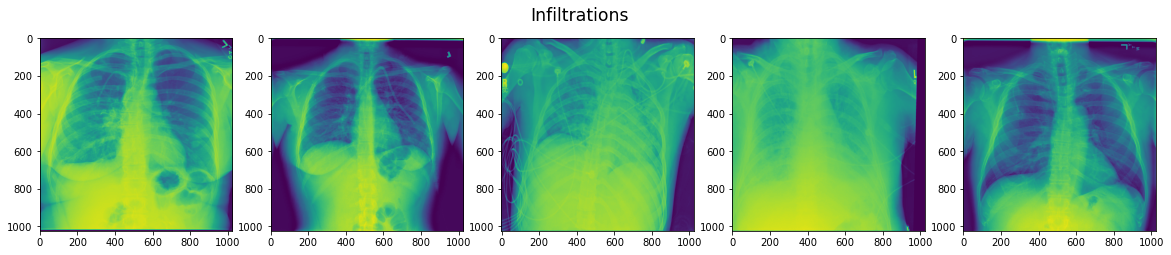

In [149]:
num_imgs = 5

fig, axs = plt.subplots(1,num_imgs, figsize=(20, 10))

for idx, image in enumerate(Infil_images):
    img = imageio.imread(image)
    axs[idx].imshow(img)
    if idx == (num_imgs-1):
        fig.suptitle('Infiltrations', y=0.68,fontsize='xx-large')    
        plt.show()
        break

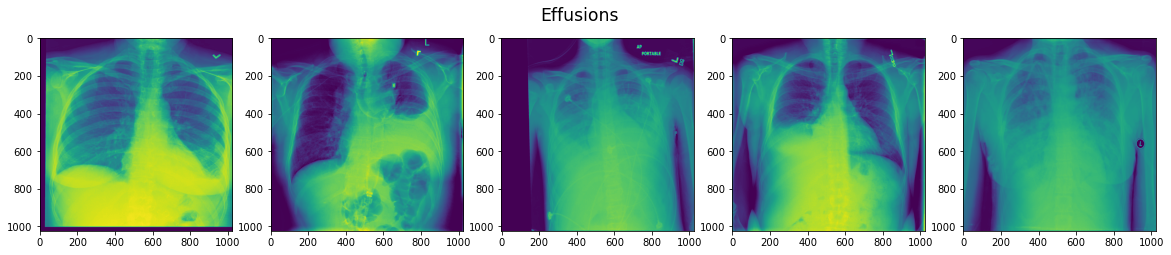

In [150]:
num_imgs = 5

fig, axs = plt.subplots(1,num_imgs, figsize=(20, 10))

for idx, image in enumerate(Eff_images):
    img = imageio.imread(image)
    axs[idx].imshow(img)
    if idx == (num_imgs-1):
        fig.suptitle('Effusions', y=0.68,fontsize='xx-large')    
        plt.show()
        break

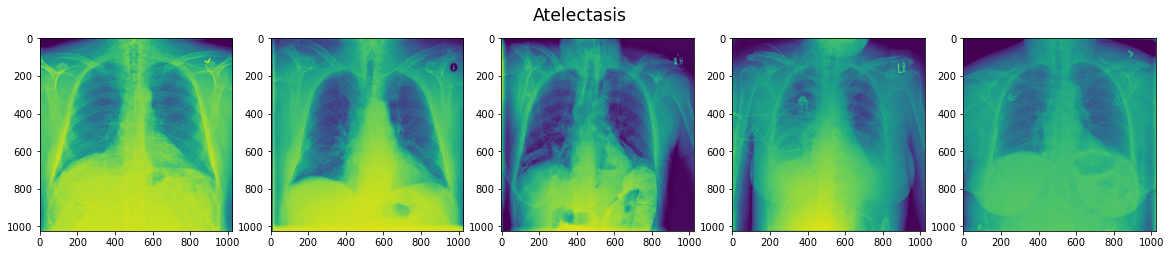

In [151]:
num_imgs = 5

fig, axs = plt.subplots(1,num_imgs, figsize=(20, 10))

for idx, image in enumerate(Ate_images):
    img = imageio.imread(image)
    axs[idx].imshow(img)
    if idx == (num_imgs-1):
        fig.suptitle('Atelectasis', y=0.68,fontsize='xx-large')    
        plt.show()
        break

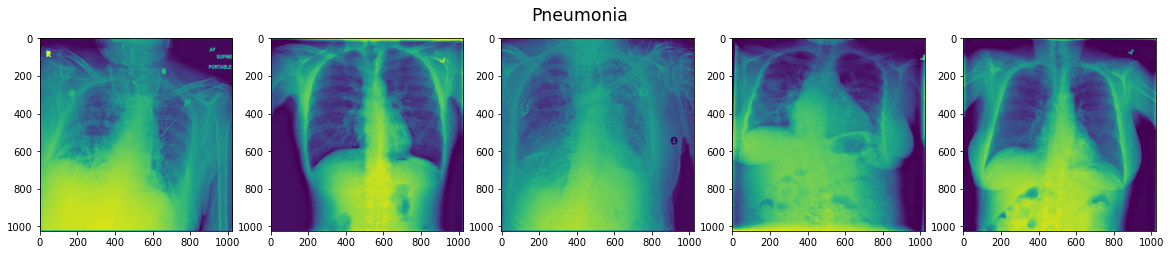

In [152]:
num_imgs = 5

fig, axs = plt.subplots(1,num_imgs, figsize=(20, 10))

for idx, image in enumerate(Pneuma_images):
    img = imageio.imread(image)
    axs[idx].imshow(img)
    if idx == (num_imgs-1):
        fig.suptitle('Pneumonia', y=0.68,fontsize='xx-large')    
        plt.show()
        break

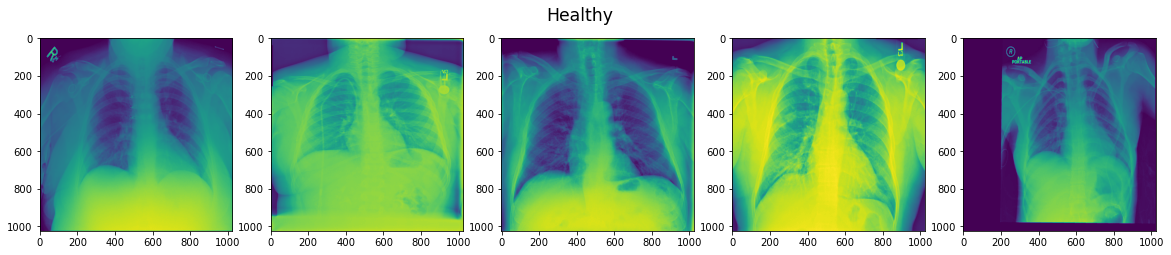

In [156]:
num_imgs = 5

fig, axs = plt.subplots(1,num_imgs, figsize=(20, 10))

for idx, image in enumerate(Healthy_images):
    img = imageio.imread(image)
    axs[idx].imshow(img)
    if idx == (num_imgs-1):
        fig.suptitle('Healthy', y=0.68,fontsize='xx-large')    
        plt.show()
        break

(array([389524.,  53411.,  90541., 109040., 125846.,  80040.,  84999.,
         79603.,  34455.,   1117.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

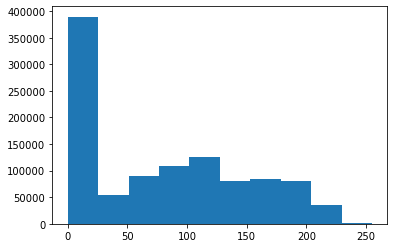

In [159]:
plt.hist(img.ravel())

In [161]:
len(img.ravel())

1048576

In [247]:
density_stats = pd.DataFrame(columns=['Finding', 'dark', 'mode','mean'])

In [226]:
density_stats.head()

,Finding,dark,mode


In [218]:
from scipy import stats

Text(0.5, 1.0, 'Infiltration intensities')

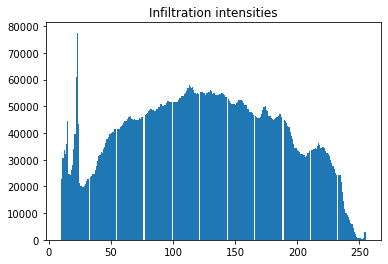

In [248]:
#num_imgs = 5

#fig, axs = plt.subplots(1,num_imgs, figsize=(20, 10))
bigarry = np.zeros(0)
big_histo = []
for idx, image in enumerate(Infil_images):
    img = imageio.imread(image)
    bigarry= np.append(bigarry, img.ravel())
    

density_stats = density_stats.append({'Finding': 'Infiltration',
                     'dark': len(bigarry[bigarry<10]),
                                     'mode':stats.mode(bigarry[bigarry < 30])[0],
                                      'mean': bigarry.mean(),
                                     }, ignore_index = True)
_ = plt.hist(bigarry, bins=256,range=(10, bigarry.max()))
plt.title("Infiltration intensities")

Text(0.5, 1.0, 'Effusion intensities')

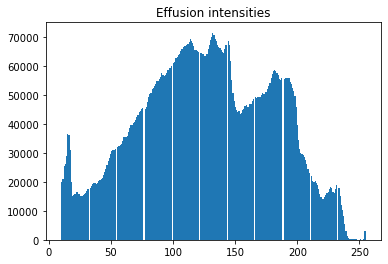

In [249]:
bigarry = np.zeros(0)
big_histo = []
for idx, image in enumerate(Eff_images):
    img = imageio.imread(image)
    bigarry= np.append(bigarry, img.ravel())
density_stats = density_stats.append({'Finding': 'Effusion',
             'dark': len(bigarry[bigarry<10]),
                             'mode':stats.mode(bigarry[bigarry < 30])[0],
                              'mean': bigarry.mean(),
                             }, ignore_index = True)

_ = plt.hist(bigarry, bins=256, range=(10, bigarry.max()))
plt.title("Effusion intensities")

Text(0.5, 1.0, 'Atelectasis intensities')

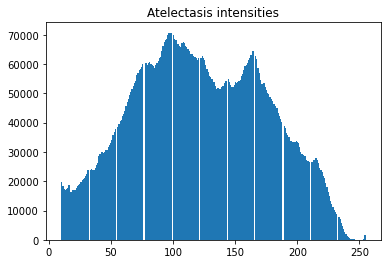

In [250]:
bigarry = np.zeros(0)
big_histo = []
for idx, image in enumerate(Ate_images):
    img = imageio.imread(image)
    bigarry= np.append(bigarry, img.ravel())
density_stats = density_stats.append({'Finding': 'Atelectasis',
                 'dark': len(bigarry[bigarry<10]),
                                 'mode':stats.mode(bigarry[bigarry < 30])[0],
                                  'mean': bigarry.mean(),
                                 }, ignore_index = True)

_ = plt.hist(bigarry, bins=256, range=(10, bigarry.max()))
plt.title("Atelectasis intensities")

Text(0.5, 1.0, 'Pneumonia intensities')

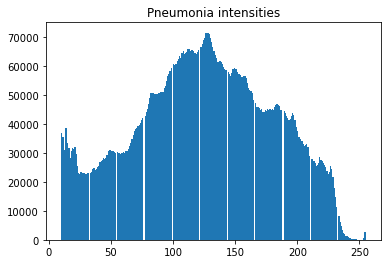

In [251]:
bigarry = np.zeros(0)
big_histo = []
for idx, image in enumerate(Pneuma_images):
    img = imageio.imread(image)
    bigarry= np.append(bigarry, img.ravel())
density_stats = density_stats.append({'Finding': 'Pneumonia',
             'dark': len(bigarry[bigarry<10]),
                             'mode':stats.mode(bigarry[bigarry < 30])[0],
                              'mean': bigarry.mean(),
                             }, ignore_index = True)

_ = plt.hist(bigarry, bins=256, range=(10,bigarry.max()))
plt.title("Pneumonia intensities")

Text(0.5, 1.0, 'Healthy intensities')

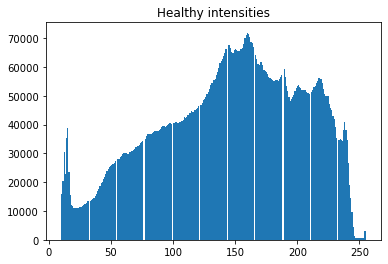

In [252]:
bigarry = np.zeros(0)
big_histo = []
for idx, image in enumerate(Healthy_images):
    img = imageio.imread(image)
    bigarry= np.append(bigarry, img.ravel())
density_stats = density_stats.append({'Finding': 'Healthy',
                 'dark': len(bigarry[bigarry<10]),
                                 'mode':stats.mode(bigarry[bigarry < 30])[0],
                                  'mean': bigarry.mean(),
                                 }, ignore_index = True)
_ = plt.hist(bigarry, bins=256, range=(10,bigarry.max()))
plt.title("Healthy intensities")

In [253]:
density_stats

,Finding,dark,mode,mean
0,Infiltration,631304,[0.0],116.888231
1,Effusion,794916,[0.0],116.775169
2,Atelectasis,596014,[0.0],114.982705
3,Pneumonia,757185,[0.0],115.394547
4,Healthy,490328,[0.0],137.715603


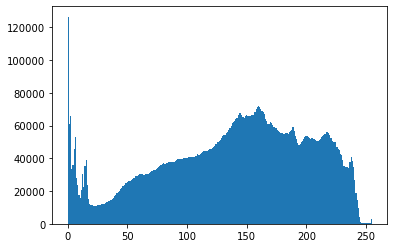

In [254]:
_ = plt.hist(bigarry, bins=256)

In [166]:
big_histo = []

type(big_histo)

list

In [167]:
big_histo.append(img.ravel())

(array([[ 26603.,  15061.,  50467.,  73613.,  86389., 114891., 166691.,
         201894., 241323.,  71644.],
        [209693.,  66383.,  92893., 101807., 102602., 120394., 118324.,
         113880., 110739.,  11861.],
        [ 76943.,  22796.,  30966.,  50667., 139014., 283807., 239772.,
         203301.,   1310.,      0.],
        [103904.,  16042.,  15912.,  27534.,  50315., 132031., 335007.,
         241685., 125759.,    387.],
        [101003.,  63208., 127879., 146042., 151510., 149875., 128253.,
          99066.,  64371.,  17369.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 5 BarContainer objects>)

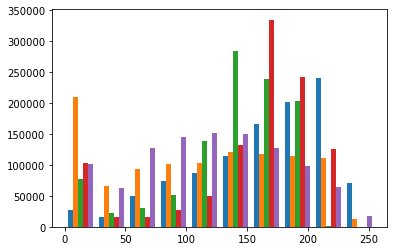

In [172]:
plt.hist(big_histo)